# Course Recommender: Content-Based Methods

This project implements and deploys an AI course Recommender System using [Streamlit](https://streamlit.io/). It was inspired by the the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning) offered by IBM & Coursera. In the last course/module of the Specialization, Machine Learning Capstone, a similar application is built; check my [class notes](https://github.com/mxagar/machine_learning_ibm/tree/main/06_Capstone_Project/06_Capstone_Recommender_System.md) for more information.

This notebook researches and implements different **Content-Based** recommender systems. You can open it in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/course_recommender_streamlit/blob/main/notebooks/03_Content_RecSys.ipynb)

In this notebook, the following content-based recommender systems are built:

1. Recommendations based on user profiles:
    - We consider that the course-genre weights are known.
    - We have a user profile, i.e., a matrix which contains the weight each user gives to a genre/feature. These weights are not normalized.
    - The rating of a user to a new item can be estimated by multiplying (dot product) the user profile vectors with the feature vector of the item. Since there is no normalization, we call that estimation score.
2. Recommendations based on course similarities:
    - We have computed course similarities (matrix) using the BoWs of course descriptions in the FE notebook.
    - For each test user with the list of courses he/she took, we get the list of unattended courses with a similarity larger than a threshold value.
3. Recommendations based on user profile clustering:
    - User profiles are reduced to less dimensions with PCA.
    - User profiles are clustered with K-Means applying the elbow method for k value discovery
    - For each user in a cluster, his un-attended courses are found.
    - For each user cluster, the most attended courses are listed.
    - For each user, the most attended courses in theirs cluster are recommended, if these were not visited by them yet.

Table of contents:

- [Part 1](#Part-1): User Profile Applied to Course Features
    - [1. Load and Understand New Datasets](#1.-Load-and-Understand-New-Datasets)
    - [2. Get Recommendations for One User](#2.-Get-Recommendations-for-One-User)
    - [3. Compute Expected Scores](#3.-Compute-Expected-Scores)
- [Part 2](#Part-2): Course Similarities
    - [1. Get Indexing Objects for Similarities and Courses](#1.-Get-Indexing-Objects-for-Similarities-and-Courses)
    - [2. Compute Recommended Courses Based on Course Similarities](#2.-Compute-Recommended-Courses-Based-on-Course-Similarities)
- [Part 3](#Part-3): Clustering User Profiles
    - [1. PCA Dimensionality Reduction](#1.-PCA-Dimensionality-Reduction-of-User-Profiles)
    - [2. K-Means Clustering of User Profiles](#2.-K-Means-Clustering-of-User-Profiles)
    - [3. Generate Course Recommendations Based on the Popular Courses in the Same Cluster](#3.-Generate-Course-Recommendations-Based-on-the-Popular-Courses-in-the-Same-Cluster)
    


In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [53]:
# Set a random state
rs = 123

# Part 1

User Profile Applied to Course Features.

# 1. Load and Understand New Datasets

In [119]:
test_users_df = pd.read_csv('../data/rs_content_test.csv')
profile_df = pd.read_csv('../data/user_profile.csv')
course_genres_df = pd.read_csv('../data/course_genre.csv')

In [120]:
# Course vs Genre: (307, 16)
course_genres_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [121]:
course_genres_df.shape

(307, 16)

In [122]:
# User vs Genre/Topic weight/preference: (33901, 15)
profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [123]:
profile_df.shape

(33901, 15)

In [124]:
# User - course - rating: (9402, 3)
test_users_df.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [125]:
test_users_df.shape

(9402, 3)

In [126]:
# There are 1000 unique users in test_users_df
len(test_users_df['user'].unique())

1000

# 2. Get Recommendations for One User

In [127]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()

In [128]:
test_user_ids[:5]

[37465, 50348, 52091, 70434, 85625]

In [129]:
test_user_profile = profile_df[profile_df['user'] == test_user_ids[0]] # user 37465
test_user_profile

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
210,37465,12.0,0.0,3.0,3.0,0.0,0.0,0.0,6.0,12.0,0.0,0.0,3.0,0.0,0.0


In [130]:
# Vector of user profile: (14,)
test_user_vector = test_user_profile.iloc[0, 1:].values
test_user_vector # (14,)

array([12.,  0.,  3.,  3.,  0.,  0.,  0.,  6., 12.,  0.,  0.,  3.,  0.,
        0.])

In [131]:
enrolled_courses = test_users_df[test_users_df['user'] == test_user_ids[0]]['item'].to_list()
enrolled_courses = set(enrolled_courses) # 7 courses

In [132]:
# The selected user has enrolled to 7 courses
# so 300 ratings are missing, i.e., these can be estimeated/predicted
enrolled_courses

{'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0211EN',
 'DS0101EN',
 'DS0201EN',
 'SC0101EN'}

In [133]:
all_courses = set(course_genres_df['COURSE_ID'].values) # 307 courses

In [134]:
unknown_courses = all_courses.difference(enrolled_courses)

In [135]:
# Get the subset of course-genre table which contains the unkown courses
unknown_course_genres = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
# Matrix
course_matrix = unknown_course_genres.iloc[:, 2:].values
course_matrix # (300, 14)

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [136]:
# Estimated rating/score for each of the 300 courses
# Note that this rating is not normalized...
np.dot(course_matrix,test_user_vector) # (300,)

array([ 3.,  6.,  3., 27.,  3.,  3.,  6.,  0.,  0., 12.,  3., 15.,  6.,
        6.,  0.,  0.,  3.,  3., 24.,  0., 15.,  0.,  3.,  0.,  6.,  6.,
        6.,  3., 27.,  6., 12.,  3.,  3.,  0., 12., 12., 27.,  9.,  6.,
       27.,  3.,  0.,  0.,  6.,  6., 12.,  3.,  3.,  6.,  3.,  0., 24.,
        6.,  3., 24.,  6.,  6.,  6., 18.,  6.,  0.,  0.,  3.,  6.,  0.,
        3.,  3.,  6.,  0.,  3., 12.,  3.,  3.,  0.,  3.,  0., 12., 12.,
        6.,  3.,  3., 12.,  3., 12., 15.,  3., 12.,  3.,  0.,  0.,  3.,
       15., 24., 15., 15., 24.,  6.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3., 15.,  0.,  3.,  3.,  0.,  3., 12.,  3.,  6.,  0.,  3.,
        3., 15.,  3., 12., 12.,  3.,  3., 24.,  0.,  3.,  6.,  6.,  6.,
        0.,  6.,  6.,  3.,  3.,  3.,  3.,  6.,  3.,  0.,  3.,  3.,  0.,
        3.,  3.,  6.,  0.,  0.,  3.,  0.,  9.,  6.,  0.,  0.,  0.,  3.,
        3.,  3.,  3.,  3.,  3.,  0.,  3.,  3., 24., 24.,  0.,  3.,  3.,
        0.,  3.,  3., 12.,  3.,  3.,  3.,  0., 12.,  3., 18., 15

# 3. Compute Expected Scores

In this section, the computations from the previous one are packed into a function which analyzes the entire test set of users. For each missing course of a student in the set a score is estimated.

In [137]:
def generate_recommendation_scores(profile_df, course_genres_df, test_users_df, score_threshold=10):
    """Generate recommendation scores
    for the users/students in the test set.
    A score is computed for each missing course.
    """
    users = []
    courses = []
    scores = []
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    for user_id in test_user_ids:
        test_user_profile = profile_df[profile_df['user'] == user_id] # df (1,15)
        # get user vector for the current user id
        test_user_vector = test_user_profile.iloc[:,1:].values[0] # np.array (1,14)
        
        # get the unknown course ids for the current user id
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        unknown_course_matrix = unknown_course_df.iloc[:, 2:].values # np.array (293,14)
        
        # user np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(unknown_course_matrix, test_user_vector)

        # Append the results into the users, courses, and scores list
        for i in range(0, len(unknown_course_ids)):
            score = recommendation_scores[i]
            # Only keep the courses with high recommendation score
            if score >= score_threshold:
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(recommendation_scores[i])
                
    return users, courses, scores

In [138]:
# Return users, courses, and scores lists for the dataframe
users, courses, scores = generate_recommendation_scores(profile_df, course_genres_df, test_users_df)

In [139]:
res_dict = dict()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
# Save the dataframe 
res_df.to_csv("../data/profile_rs_results.csv", index=False)

In [140]:
res_df.head()

,USER,COURSE_ID,SCORE
0,37465,RP0105EN,27.0
1,37465,GPXX06RFEN,12.0
2,37465,CC0271EN,15.0
3,37465,BD0145EN,24.0
4,37465,DE0205EN,15.0


In [142]:
# On average, how many new courses have been recommended per test user?
res_df.groupby('USER')['COURSE_ID'].count().mean()

61.81828703703704

In [143]:
# What are the most frequently recommended courses?
# Return the top-10 commonly recommended courses across all test users.
res_df.groupby('COURSE_ID').count()['USER'].sort_values(ascending=False)[:10]

COURSE_ID
TA0106EN      608
GPXX0IBEN     548
excourse22    547
excourse21    547
ML0122EN      544
excourse06    533
excourse04    533
GPXX0TY1EN    533
excourse31    524
excourse73    516
Name: USER, dtype: int64

# Part 2

Course Similarities.

## 1. Get Indexing Objects for Similarities and Courses

In [145]:
sim_df = pd.read_csv('../data/sim_computed.csv')

In [146]:
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.072898,0.039276,0.121113
1,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138270,0.031367,0.076940
2,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.133400,0.012684,0.000000
3,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017443,0.018796,0.158073
4,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.129871,0.000000,0.000000


In [147]:
course_df = pd.read_csv('../data/course_processed.csv')
bow_df = pd.read_csv('../data/courses_bows.csv')
test_users_df = pd.read_csv('../data/rs_content_test.csv')
profile_df = pd.read_csv('../data/user_profile.csv')
course_genres_df = pd.read_csv('../data/course_genre.csv')
sim_df = pd.read_csv('../data/sim_computed.csv')

In [148]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    del grouped_df
    return idx_id_dict, id_idx_dict

In [149]:
course1 = course_df[course_df['COURSE_ID'] == "ML0151EN"]
course1

,COURSE_ID,TITLE,DESCRIPTION
200,ML0151EN,machine learning with r,this machine learning with r course dives into...


In [150]:
course2 = course_df[course_df['COURSE_ID'] == "ML0101ENv3"]
course2

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


In [151]:
idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


In [152]:
sim_matrix = sim_df.values

In [153]:
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

In [154]:
enrolled_course_ids = ['ML0201EN','ML0122EN'] # add course ids to the list

In [155]:
enrolled_courses = course_df[course_df['COURSE_ID'].isin(enrolled_course_ids)]
enrolled_courses

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...


In [156]:
all_courses = set(course_df['COURSE_ID'])

In [157]:
unselected_course_ids = all_courses.difference(enrolled_course_ids)
#unselected_course_ids

## 2. Compute Recommended Courses Based on Course Similarities

In [158]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    threshold = 0.6 
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                sim = 0
                # Find the two indices for each enrolled_course and unselect_course, based on their two ids
                # Calculate the similarity between an enrolled_course and an unselect_course
                # e.g., Course ML0151EN's index is 200 and Course ML0101ENv3's index is 158
                idx_enrolled = id_idx_dict[enrolled_course]
                idx_unenrolled = id_idx_dict[unselect_course]
                
                # Find the similarity value from the sim_matrix
                # sim = sim_matrix[200][158]
                sim = sim_matrix[idx_enrolled][idx_unenrolled]

                if sim > threshold:
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res

In [159]:
recommendations = generate_recommendations_for_one_user(enrolled_course_ids,
                                      unselected_course_ids,
                                      id_idx_dict,
                                      sim_matrix)

In [160]:
recommendations

{'ML0122ENv3': 0.6815739441431503}

In [161]:
def generate_recommendations_for_all(sim_matrix, course_df, test_users_df, id_idx_dict):
    users = []
    courses = []
    sim_scores = []
    all_courses = set(course_df['COURSE_ID'])
    # Get all test user ids
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    for user_id in test_user_ids:
        # For each user, call generate_recommendations_for_one_user()
        # to generate the recommendation results
        enrolled_course_ids = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unselected_course_ids = all_courses.difference(enrolled_course_ids)
        recommendations = generate_recommendations_for_one_user(enrolled_course_ids,
                                                                unselected_course_ids,
                                                                id_idx_dict,
                                                                sim_matrix)
        # Save the result to courses, sim_scores list
        n = 0
        for course, sim in recommendations.items():
            courses.append(course)
            sim_scores.append(sim)
            n += 1
        if n > 0:
            user_ids = [user_id for i in range(n)]
            #print(user_ids)
            users.extend(user_ids)
    
    return users, courses, sim_scores

In [162]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all(sim_matrix,
                                                              course_df,
                                                              test_users_df,id_idx_dict)
#print(len(users), len(courses), len(sim_scores))
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

In [163]:
# Recommended courses for all students
# based on course similarity
res_df

,USER,COURSE_ID,SCORE
0,37465,DS0110EN,0.732941
1,37465,excourse67,0.708214
2,37465,excourse63,0.694563
3,37465,excourse72,0.652535
4,37465,excourse74,0.650071
...,...,...,...
11372,2087663,excourse28,0.623754
11373,2087663,BD0145EN,0.623544
11374,2087663,excourse68,0.616759
11375,2087663,excourse60,0.615568


In [165]:
# On average, how many new courses have been recommended per test user?
res_df.groupby('USER')['COURSE_ID'].count().mean()

11.573753814852493

In [166]:
# What are the most frequently recommended courses?
# Return the top-10 commonly recommended courses across all test users.
res_df.groupby('COURSE_ID').count()['USER'].sort_values(ascending=False)[:10]

COURSE_ID
excourse62    579
excourse22    579
DS0110EN      562
excourse65    555
excourse63    555
excourse72    551
excourse68    550
excourse74    539
excourse67    539
BD0145EN      506
Name: USER, dtype: int64

# Part 3

Clustering User Profiles.

In [85]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [101]:
user_profile_df = pd.read_csv('../data/user_profile.csv')
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


## 1. PCA Dimensionality Reduction of User Profiles

In [88]:
# Extract user features + scale them
feature_names = list(user_profile_df.columns[1:])
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']

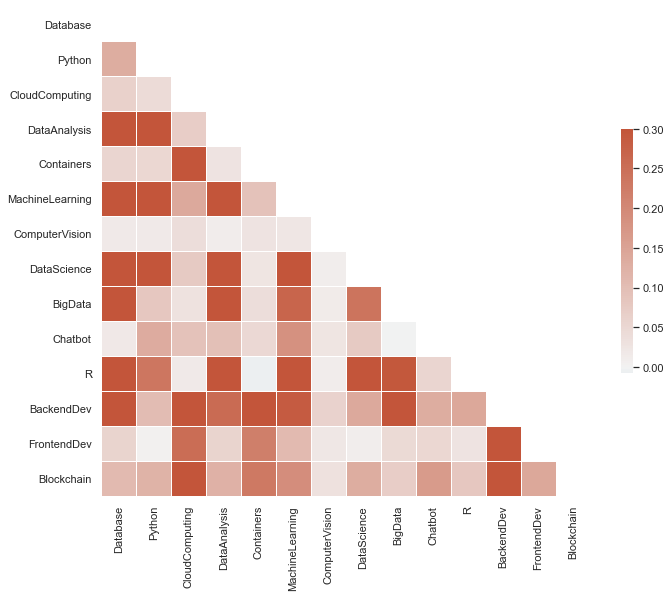

In [89]:
# Plot correlations between features: there are many
# thus, applying PCA makes sense
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

In [91]:
# PCA applied to user profiles
pca = PCA(n_components = features.shape[1])
features_pca = pca.fit_transform(features)

# Explained variance of each principal component
explained_variance = pca.explained_variance_ratio_

# Sum all explained variances until 95% is reached;
# how many components do we need?
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.90) + 1

In [92]:
# Accumulated variances for each number of components
cumsum

array([0.28756843, 0.46309256, 0.57613396, 0.64874656, 0.71948788,
       0.78821034, 0.84295585, 0.89444455, 0.92726956, 0.95446582,
       0.97335721, 0.98703108, 0.99791632, 1.        ])

In [93]:
# Number of components to have at least 90% of variance explained
d

9

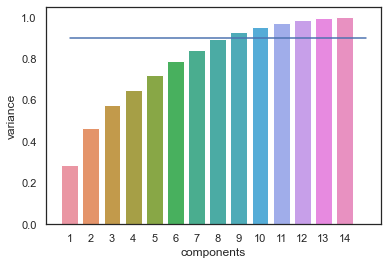

In [94]:
# Plot explained varianve accumulation
component_variance_df = pd.DataFrame(data=cumsum.ravel(), columns=['variance'])
component_variance_df['components'] = range(1,features.shape[1]+1)
bplot = sns.barplot(data=component_variance_df, x='components', y = 'variance')
plt.plot([0,features.shape[1]], [0.9, 0.9])

In [95]:
# New user profiles
features_pca_df = pd.DataFrame(data=features_pca[:,:d])
features_pca_df.columns = ['PC'+str(v) for v in range(d)]
features_pca_df = pd.concat([user_ids, features_pca_df], axis=1)
features_pca_df.head()

,user,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379


## 2. K-Means Clustering of User Profiles

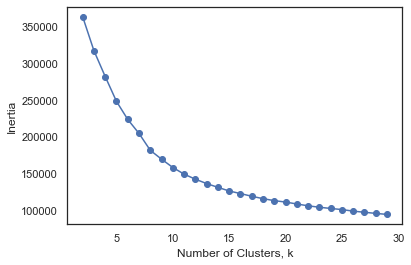

In [96]:
# Apply K-Means with Elbow method to get optimal number of clusters
inertia = []
clusters = list(range(2,30))
for k in clusters:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    random_state=101) # always define it!
    kmeans.fit(features_pca[:,:d])
    inertia.append(kmeans.inertia_)
# Plot k vs inertia
plt.plot(clusters,inertia)
plt.scatter(clusters,inertia)
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia');

In [97]:
# Selected number of clusters
kmeans = KMeans(n_clusters=11, # 9
                init='k-means++',
                random_state=rs) # always define it!
# Fit dataset
kmeans.fit(features)
cluster_labels = kmeans.labels_

In [102]:
# JOIN user id and cluster
def combine_cluster_labels(user_ids, cluster_labels):
    labels_df = pd.DataFrame(cluster_labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [99]:
cluster_df = combine_cluster_labels(user_ids, cluster_labels)

In [100]:
cluster_df.head()

,user,cluster
0,2,4
1,4,2
2,5,4
3,7,1
4,8,1


## 3. Generate Course Recommendations Based on the Popular Courses in the Same Cluster

In [103]:
test_users_df = pd.read_csv('../data/rs_content_test.csv')[['user', 'item']]
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


In [104]:
# We perform a JOIN to assing to each test user his/her cluster
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')

In [105]:
test_users_labelled.head()

,user,item,cluster
0,1502801,RP0105EN,3
1,1502801,BD0131EN,3
2,1502801,BD0212EN,3
3,1502801,BD0115EN,3
4,1502801,BD0211EN,3


In [106]:
courses_cluster = test_users_labelled[['item', 'cluster']]
courses_cluster['count'] = [1] * len(courses_cluster)
# For each cluster and course (item), the number of enrollments
courses_cluster = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()

In [107]:
courses_cluster.head()

,cluster,item,enrollments
0,0,BC0101EN,8
1,0,BC0201EN,3
2,0,BD0101EN,7
3,0,BD0111EN,4
4,0,BD0115EN,2


<AxesSubplot:ylabel='Frequency'>

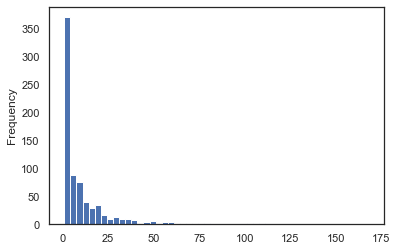

In [108]:
courses_cluster['enrollments'].plot(kind='hist', bins=50)

In [110]:
course_df = pd.read_csv('../data/course_processed.csv')
all_courses = set(course_df['COURSE_ID'])
enrollments_threshold = 75

In [111]:
# For each user, first finds its cluster label
# First get all courses belonging to the same cluster and figure out
# what are the popular ones (such as course enrollments beyond a threshold like 100)
# Get the user's current enrolled courses
# Check if there are any courses on the popular course list which are new/unseen to the user. 
# If yes, make those unseen and popular courses as recommendation results for the user
users = []
courses = []
clusters = []
for user in cluster_df['user'].to_list():
    cluster = cluster_df[cluster_df.user == user]['cluster'].unique()[0]
    enrolled_courses_ids = test_users_labelled[test_users_labelled.user == user].item.to_list()
    unselected_course_ids = all_courses.difference(enrolled_courses_ids)
    candidate_courses = courses_cluster[(courses_cluster.cluster == cluster) &
                                        (courses_cluster.enrollments > enrollments_threshold)]['item'].to_list()
    for course in unselected_course_ids:
        if course in candidate_courses:
            users.append(user)
            courses.append(course)
            clusters.append(cluster)

In [112]:
recommended_courses = pd.DataFrame(data=users, columns = ['user'])
recommended_courses['cluster'] = clusters
recommended_courses['course'] = courses

In [114]:
# Courses recommended to eeach test user
# based on the cluster they belong to
# and their most visited courses in that cluster
# that were still not attended by them
recommended_courses.head(10)

,user,cluster,course
0,7,1,BD0101EN
1,7,1,DS0101EN
2,7,1,PY0101EN
3,8,1,BD0101EN
4,8,1,DS0101EN
5,8,1,PY0101EN
6,9,3,BD0101EN
7,9,3,BD0111EN
8,9,3,BD0211EN
9,9,3,BD0115EN


In [167]:
# On average, how many new courses have been recommended per test user?
recommended_courses.groupby('user')['course'].count().mean()

2.9663975492229633

In [168]:
# What are the most frequently recommended courses?
# Return the top-10 commonly recommended courses across all test users.
recommended_courses.groupby('course').count()['user'].sort_values(ascending=False)[:10]

course
PY0101EN      18517
DS0101EN      15561
BD0101EN      14381
ML0115EN       5249
DV0101EN       5223
ML0101ENv3     5213
DA0101EN       5195
BD0115EN       4079
BD0211EN       4041
BD0111EN       4019
Name: user, dtype: int64